#  ML with TF-IDF (movie rating)
- read and prepare training data (read positive and negative data)
- split training data into train and test
- run different classifier
    - naive Bayes
    - random forests
    - support vector machine
    - multi- layer perceptron (MLP)
- evaluate / compare

### Tasks:
- pre-process features in different ways, as in the previous task:  
    - lower case, stemmer (porter, ours)
    - replace (NER)
    - compute TF-IDF / w2v (1, 2, .. n-grams)
    - filter most important terms/reduce vector size
- compare precision, recall accuracy of classifiers for vector sizes
- modify parameters of classifiers
- fold cross validation (using different training/testing) sets
- document and report in a markup cell 

## TF-IDF
- documents collection $D: \{d_1 ... d_n\}$
- terms $t_i$

-----
Term Frequency (TF):
- TF($t,d$) = $\frac{\mbox{Number of times term $t$ appears in document $d$}} {\mbox{Total number of terms in the document $d$}}$

Inverse Document Frequncy (IDF):

- IDF($t,D$) = $log(\frac{\mbox{Number of documents $d$ in the corpus ($|d \in D|$)}} {\mbox{number of documents $d \in D$ where the term $t$ appears}})$

TF-IDF:
- TF-IDF($t, d, D$) = TF($t, d$) * IDF($t,D$)

-----
Functions:
- T = TF_IDF(D): Train TF_IDF structure for document collection D  
- W = TF_IDFvector(D, T): Return vector of tf-idf values
- L = labelVector(W, T, m=1): Return vector of labels, (m highest terms per document)
- B = bestTFIDF(D, n=10): Return union of n highest-ranked terms per document in collection
- nBestIndex(T, nBest): re-assign TF_IDF structure for nBest terms


# This projects has markdown cells to document what is happinging in each cell in addition to some comments in the code
## NOTE: Both of us will submit the python script but they are the same

## Importing the Required Libraries

In [22]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string


import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tag import pos_tag
from nltk import ne_chunk

# Mohammad
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
import re
from bs4 import BeautifulSoup


# Read n files from directory and preprocess

This code snippet defines a function `ReadSourceTok` and a helper function `preprocessSent`.

## Function: `ReadSourceTok(dic, n=100, tag=False, verbose=0)`
- **Purpose**: Reads and preprocesses documents from a specified directory.
- **Returns**: A dictionary `D` where each document `doc` is represented as a list of preprocessed sentences `sent`, which in turn is represented as a list of preprocessed words `word`.

## `preprocessSent(sent)`
- **Purpose**: Preprocesses a single sentence.
- **Parameters**:
  - `sent`: Input sentence to be preprocessed.
- **Returns**: The preprocessed sentence.

## Preprocessing Steps:
1. Remove HTML tags using BeautifulSoup.
2. Remove punctuation and numbers using regular expressions.
3. Tokenize the sentence and perform part-of-speech tagging.
4. Handle contractions like "n't" and combine them with the following word.
5. Remove named entities recognized by NLTK's named entity recognition.
6. Remove stopwords and stem the remaining words using the Porter Stemmer algorithm.

### Why Did We Choose These Steps?

1. **Removing HTML Tags, Numbers, and Punctuation**:
   - **Purpose**: HTML tags, numbers, and punctuation do not contribute to the semantic meaning of the text and only add noise to the data. Removing them helps reduce the dimensionality of vector.

2. **Removing Stopwords**:
   - **Purpose**: Stopwords are common words (e.g., "the", "is", "and") that occur frequently in the text but often do not carry significant meaning. Removing stopwords also reduces the size of the vector.

3. **Handling Contractions (e.g., "n't")**:
   - **Purpose**: Contractions like "n't" (e.g., "not") can significantly change the meaning of words (e.g., "happy" vs. "not happy"). Concatenating "not" with the following word (e.g., "not_happy") preserves the negation context, ensuring that the sentiment conveyed by the word is correctly captured during subsequent analysis.

4. **Stemming**:
   - **Purpose**: Stemming reduces words to their root or base form, which helps in capturing the core meaning of words and reduces the size of the vector (e.g using and use will be the same ).




In [23]:
# Read n files from directory and preprocess
# return: D[doc][sent][word]

def ReadSourceTok(dic, n=100,  tag = False, verbose = 0) :
    D = {}
    i = 0

    # Read sorted file names
    for f in sorted(Path(dic).iterdir()):
        if(verbose == 1): print(f.resolve())
        if (i == n): break
        i += 1
        
        with f.open('r', encoding='utf-8') as fhin: data = fhin.read()
            
        # get the file basename as index for document
        b = os.path.basename(f).split(".")[0]
        
        # document is a string of tokens
        D[b] = preprocessSent(data)
    return D

   
def preprocessSent(sent):
    soup = BeautifulSoup(sent, "html.parser")
    sent = soup.get_text()
    words = sent.split(' ')
    for i, word in enumerate(words):
        if "'t" in word:
            words[i] = word.replace("'t", " not")
    sent = " ".join(words)
    sent = sent.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    sent = re.sub(r'\d+', '', sent)
    tagged_words = pos_tag(words)
    processed_words = []
    i = 0
    while i < len(tagged_words):
        word, tag = tagged_words[i]
        if word == "not" and i < len(tagged_words) - 1:
            processed_words.append(word + "_" + tagged_words[i+1][0])
            i += 2
        else:
            processed_words.append(word)
            i += 1
    tagged_words = pos_tag(processed_words)
    named_entities = nltk.ne_chunk(tagged_words)
    processed_words2 = []
    for word in named_entities:
        if not isinstance(word, nltk.tree.Tree):
            # If it's a named entity, replace it with 'NER'
            processed_words2.append(word[0].lower())
    # add here additional preprocessing steps
    # Remove stopwords
    
    stop_words = set(stopwords.words('english'))
    processed_words2 = [word for word in processed_words2 if word not in stop_words]
    porter_stemmer = PorterStemmer()
    stemmed_words = [porter_stemmer.stem(word) for word in processed_words2]
    
    sent = " ".join(stemmed_words)        
    return sent


### Example
It is just a small exaple to see how the preprocessSent() function works

In [24]:
example_text = "Processing text with Porter Stemmer and custom stemming algorithm"
result= preprocessSent(example_text)
result

'process text custom stem algorithm'

# Function to Label Sparse Vectors Based on Top Features
The **labelVector** function labels a collection of sparse vectors by identifying the top features from each vector. 

## Parameters:
1. **vectors**: An iterable of sparse vectors.
2. **model**: An object that provides the feature names (like a TfidfVectorizer in scikit-learn).
3. **m**: The number of top features to extract from each vector (default is 1).

## Workflow:
1. **Initialization:**
    - Create an empty list labels to store the labels for each vector.
2. **Processing Each Vector:**
    - Loop through each vector in vectors.
    - Determine the indices of the top m features with the highest values in the vector. This is done using np.argsort(vector.data)[-m:][::-1].
    - Ensure the indices are within bounds by filtering out indices larger than the number of feature names.
    - Extract the top terms using these indices: [(feature_names[vector.indices[i]], vector.data[i])]. This list comprehension pairs the feature names with their corresponding values.
    - Sort the top terms by their values in descending order using top_terms.sort(key=lambda x: x[1], reverse=True).
    - Extract the feature names from the sorted list of top terms to get the top labels.
3. **Appending to Labels:**
    - Append the list of top labels to the labels list for each vector.
4. **Return:**
    - The function returns the labels list containing the top labels for each vector.

## How did we use this function?
 We were trying to get the m best words in the positive documents and negative ones (according to their TFIDF scores) and then refeed them to the machine from the beginning to make judgements later based on these words only instead of all the words in the documents. This approach obviously reduced the size of the vector and helped us read more and more files as it solved the space constraint, but we noticed that the accuracy dropped significantly as expected (to 0.4 or less).  

In [49]:
def labelVector(vectors, model, m=1): 
    labels = []
    feature_names = model.get_feature_names()
    for vector in vectors:
        top_indices = vector.argsort()[-m:][::-1]
        top_terms = [(feature_names[i], vector[i]) for i in top_indices]
        top_terms.sort(key=lambda x: x[1], reverse=True)
        top_labels = [term[0] for term in top_terms]
        labels.append(top_labels)
    return labels

### Reading Files

We read a total of 1600 documents( 800 positive and 800 negative). Due to resource limitations on this server, we were unable to read more documents. However, by performing data cleaning and removing unnecessary words during the preprocessing step, we were able to increase the number of documents we could process to 1600. 


In [26]:
# add TF-IDF model for pos and neg documents
from sklearn.decomposition import IncrementalPCA
# number of docs to read
nDocs = 800

#initialize 
D1 = N1 = P1 = {}

# Read positive documents 
P1 = ReadSourceTok("/data/critt/shared/resources/aclImdb/test/pos/", n=nDocs, tag=False)

# Read negative documents 
N1 = ReadSourceTok("/data/critt/shared/resources/aclImdb/test/neg/", n=nDocs, tag=False)

# join the Pos and the Neg corpus
D1 = {**P1,**N1}

print(f"#Pos:{len(P1)} #words in Docs:{len([w for d in P1.keys() for s in P1[d] for w in s])}")
print(f"#Neg:{len(N1)} #words in Docs:{len([w for d in N1.keys() for s in N1[d] for w in s])}")
print(f"#Sum:{len(D1)} #words in Docs:{len([w for d in D1.keys() for s in D1[d] for w in s])}")


/usr/local/lib/python3.6/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


#Pos:800 #words in Docs:604412
#Neg:800 #words in Docs:589626
#Sum:1600 #words in Docs:1194038


### Code Explanation:


1. **Creation of TF-IDF Vectorizer**:
   - A TF-IDF vectorizer (`tfidf`) is created with unigram (1-gram) range. This means that only single words are considered as features for vectorization.
   
2. **Reasoning for Using Unigram Range**:
   - The decision to use a unigram range is based on the preprocessing steps performed earlier. By removing stopwords, many meaningful sequences such as "very good" have been broken. Additionally, by concatenating "not" with the following word (e.g., "not_good"), the two words are treated as one token with the full meaning of a bigram (2-gram), such as "not good" = "bad".
   - Therefore, there is no need to use more than one gram in the TF-IDF vectorization process, as the preprocessing steps have already handled the meaningful combinations of words effectively.


In [29]:
import numpy as np

print(f"#Sum:{len(D1)} #words in Docs:{len([w for d in D1.keys() for s in D1[d] for w in s])}")
# tfidf vector 1  grams
tfidf = TfidfVectorizer(ngram_range=(1,1))

# Learn vocabulary and idf from P1 and N1 documents
tfidf.fit(D1.values())

print(f"Length of Tfidf vectors: {len(tfidf.get_feature_names())}")
 
# Transform P1 documents to document-term matrix.
Pos1 = tfidf.transform(P1.values())

# Transform N1 documents to document-term matrix.
Neg1 = tfidf.transform(N1.values())
# Transform Pos1 and Neg1 documents to document-term matrix.

Ntr1 = Neg1.toarray()  # Convert to dense array before transforming
Ptr1 = Pos1.toarray() # Convert to dense array before transforming


#Sum:1600 #words in Docs:1194038
Length of Tfidf vectors: 17593


In [30]:
Pos_labels = labelVector(Ptr1,tfidf,2)
Neg_labels = labelVector(Ntr1,tfidf,2)
print(f"#Positive labels:{Pos_labels}")
print(f"#Negative labels:{Neg_labels}")
print(f"#Docs vector Pos:{Ptr1.shape} #Docs vector Neg:{Ntr1.shape} ")

#Positive labels:[['theater', 'coax'], ['golf', 'open'], ['class', 'golf'], ['fabulous', 'job'], ['prejudic', 'golf'], ['golfer', 'golf'], ['drug', 'himself'], ['cultur', 'aspect'], ['depress', 'movi'], ['identity', 'lennon'], ['drug', 'channel'], ['spoli', 'mesmerizing'], ['foreign', 'loophol'], ['famili', 'hurt'], ['mental', 'health'], ['jia', 'film'], ['hunted', 'night'], ['porn', 'deterior'], ['memori', 'particularli'], ['desolate', 'thril'], ['woman', 'drive'], ['felix', 'cartoon'], ['deeper', 'love'], ['anim', 'silent'], ['shoe', 'boss'], ['chaplin', 'strip'], ['ham', 'cartoon'], ['cartoons', 'old'], ['havilland', 'flynn'], ['custer', 'command'], ['custer', 'militari'], ['dictatori', 'buttler'], ['custer', 'battlefield'], ['spoli', 'mesmerizing'], ['legend', 'custer'], ['custer', 'warner'], ['warner', 'dehavilland'], ['never', 'histor'], ['custer', 'war'], ['flynn', 'butler'], ['anti', 'histor'], ['battl', 'movi'], ['custer', 'indian'], ['custer', 'cav'], ['allow', 'film'], ['fly

### PCA Dimensionality Reduction:
1. **Application of PCA**:
   - PCA (Principal Component Analysis) is applied to the features (`X`) to reduce the dimensionality of the data while preserving the most important information.
   - The number of components is specified as `n_components=200`, indicating that PCA should retain 200 principal components.
2. **Why 200?**
   - after considering most of the options for the `n_components' , 200 was the best option form most of the classifiers since it gave the best accuracies for most of them. This number were the best considering 800 docs for each type and considering the same perpross steps
   


In [31]:
import pandas as pd
from sklearn.decomposition import PCA

# Assuming Ptr1 and Ntr1 are your feature matrices for positive and negative samples respectively

# Create dataframes for positive and negative samples with labels
TrainVecPos = pd.DataFrame(Ptr1)
TrainVecPos["Label"] = 1

TrainVecNeg = pd.DataFrame(Ntr1)
TrainVecNeg["Label"] = 0

# Concatenate the positive and negative dataframes
TrainVecSet3_pca = pd.concat([TrainVecPos, TrainVecNeg], axis=0)

# Separate features (X) and labels (Y)
Y = TrainVecSet3_pca['Label']
X = TrainVecSet3_pca.drop(['Label'], axis=1)

# Apply PCA to the features
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X)

# Create a new dataframe with reduced features and labels
TrainVecSet3 = pd.DataFrame(X_pca, columns=[f"PCA_{i}" for i in range(X_pca.shape[1])])
TrainVecSet3['Label'] = Y.reset_index(drop=True)  # Reset index of labels
print(TrainVecSet3)


         PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0     0.054057 -0.073073  0.100591 -0.013354 -0.028381 -0.055616 -0.018246   
1    -0.106017  0.027426  0.020031 -0.010995  0.052823  0.029953 -0.048126   
2    -0.090625 -0.054957  0.074834  0.014625  0.029072 -0.017850  0.001629   
3     0.084769  0.083155  0.081624  0.021091  0.034986 -0.034290  0.040298   
4    -0.082186  0.001183  0.102717  0.041543  0.032456 -0.034253 -0.000146   
...        ...       ...       ...       ...       ...       ...       ...   
1595  0.066213 -0.017877 -0.072605 -0.010025  0.015686  0.013605  0.031906   
1596 -0.004913 -0.011009  0.019648  0.018793 -0.052124 -0.032732 -0.022572   
1597  0.094854 -0.047298  0.039689  0.023226  0.015536 -0.046977  0.005818   
1598 -0.012139  0.009943 -0.005844 -0.005769  0.064222  0.001411  0.065654   
1599  0.109990 -0.001594 -0.007182 -0.054473 -0.052976 -0.008976  0.030643   

         PCA_7     PCA_8     PCA_9  ...   PCA_191   PCA_192   P

## prepare training and test set

In [32]:
# extracting training and test set 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# task: scale the data

# Y is label: {1,0}
Y = TrainVecSet3[['Label']]

# X is everything without label
X = TrainVecSet3.drop(['Label'], 1)

# extract train and test set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = .25)

print(f"Train:{trainX.shape} Labels Train: {trainY.shape}\tTest:{testX.shape} Labels Test: {testY.shape} ")


Train:(1200, 200) Labels Train: (1200, 1)	Test:(400, 200) Labels Test: (400, 1) 


In [33]:
## scale 
scaler = StandardScaler()  

# Fit only on training data
scaler.fit(X)

X_scale = scaler.transform(X)  

# extract train and test set
trainX, testX, trainY, testY = train_test_split(X_scale, Y, test_size = .25)

print(f"Train:{trainX.shape} Labels Train: {trainY.shape}\tTest:{testX.shape} Labels Test: {testY.shape} ")


Train:(1200, 200) Labels Train: (1200, 1)	Test:(400, 200) Labels Test: (400, 1) 


# Training the Classifiers

1. **Data Preprocessing**:
   - After preprocessing the data as described earlier, including tokenization, removing stopwords, stemming, and potentially applying dimensionality reduction techniques like PCA, the data is now ready for training.
   
2. **Classifier Training**:
     - Support Vector Machines (SVM)
     - Random Forest
     - Naive Bayes
     - MLP
   




# Naive Bayesian Classifier 

              precision    recall  f1-score   support

         Neg       0.70      0.91      0.79       193
         Pos       0.88      0.64      0.74       207

    accuracy                           0.77       400
   macro avg       0.79      0.77      0.77       400
weighted avg       0.79      0.77      0.77       400

Confusion Matrix:
 [[175  18]
 [ 74 133]]


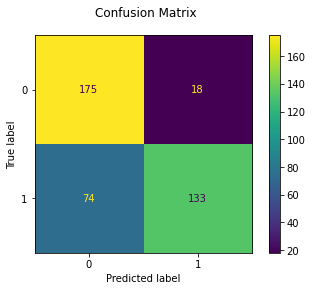

In [34]:
#Import Gaussian Naive Bayes model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
NBmodel = GaussianNB()

# Train the model using the training sets
NBmodel.fit(trainX, trainY["Label"])

#Predict Output
Y_Bayes = NBmodel.predict(testX)

target_names = ['Neg', 'Pos']
print(classification_report(testY["Label"], Y_Bayes, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_true=testY["Label"], y_pred=Y_Bayes))

fig = plot_confusion_matrix(NBmodel, testX, testY, display_labels=NBmodel.classes_)
fig.figure_.suptitle("Confusion Matrix")
plt.show()


### 10-Fold Cross-Validation (will be applied for all classifiers)

1. **Small Sample Size Consideration**:
   - Due to the relatively small sample size of the dataset, traditional train-test splitting may result in high variance in model performance metrics. Cross-validation techniques are employed to mitigate this issue and obtain more reliable estimates of model performance.

2. **Choice of Cross-Validation Technique**:
   - Leave-One-Out (LOO) cross-validation, where each sample is used as a separate test set, theoretically provides the most accurate estimation of model performance. However, it can be computationally expensive, especially for larger datasets. In this case, with a relatively small dataset, 10-fold cross-validation is chosen as a compromise between accuracy and computational efficiency.

.

3. **Benefits of 10-Fold Cross-Validation**:
   - 10-fold cross-validation provides a robust estimation of model performance while being computationally more efficient than LOO cross-validation.
   - It helps in assessing the generalization capability of the model and identifying potential overfitting or underfitting issues.
   

4. **Empirical Validation of 10-Fold Cross-Validation**:
   - Through empirical testing, it has been found that 10-fold cross-validation yields accurate estimates of model performance while being significantly faster than LOO cross-validation.


In [35]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Import necessary modules
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define custom scoring functions for precision and recall for positive and negative classes
def precision_neg(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=0)  # Negative class label is 0

def precision_pos(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=1)  # Positive class label is 1

def recall_neg(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)  # Negative class label is 0

def recall_pos(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)  # Positive class label is 1

# Extract labels (Y) and features (X)
Y = TrainVecSet3[['Label']]
X = TrainVecSet3.drop(['Label'], 1)

# Scale the features
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Create a Gaussian Classifier
NBmodel = GaussianNB()

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# Perform cross-validation
cross_val_results = cross_validate(NBmodel, X_scaled, Y["Label"], cv=cv, scoring=scoring)

results_NB = {}
# Print the cross-validation results
print("Cross-validation results:")
for metric, values in cross_val_results.items():
    results_NB[metric] = values.mean()
print(results_NB)


Cross-validation results:
{'fit_time': 0.011481356620788575, 'score_time': 0.010443854331970214, 'test_accuracy': 0.73375, 'test_precision_neg': 0.6914002736469745, 'test_precision_pos': 0.8043613943311367, 'test_recall_neg': 0.85, 'test_recall_pos': 0.6175, 'test_f1_score': 0.697203193679732}


# Random Forest

In [36]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train the model on training data
rf.fit(trainX, trainY["Label"]);

# Use the forest's predict method on the test data
Y_rf = rf.predict(testX)

target_names = ['Neg', 'Pos']
print(classification_report(testY["Label"], Y_rf, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_true=testY["Label"], y_pred=Y_rf))

# print feature Importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances 


              precision    recall  f1-score   support

         Neg       0.78      0.89      0.83       193
         Pos       0.88      0.77      0.82       207

    accuracy                           0.82       400
   macro avg       0.83      0.83      0.82       400
weighted avg       0.83      0.82      0.82       400

Confusion Matrix:
 [[171  22]
 [ 48 159]]


,importance
2,0.096882
0,0.060857
10,0.023212
3,0.019613
9,0.019073
...,...
75,0.002460
97,0.002430
109,0.002416
107,0.002369


In [37]:

# Create a Gaussian Classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# Perform cross-validation
cross_val_results = cross_validate(rf, X_scaled, Y["Label"], cv=cv, scoring=scoring)

results_RF = {}
print("Cross-validation results:")
for metric, values in cross_val_results.items():
    results_RF[metric] = values.mean()
print(results_RF)

Cross-validation results:
{'fit_time': 1.4755953550338745, 'score_time': 0.031944680213928225, 'test_accuracy': 0.83375, 'test_precision_neg': 0.8167987265223691, 'test_precision_pos': 0.8543962778539411, 'test_recall_neg': 0.8625, 'test_recall_pos': 0.805, 'test_f1_score': 0.8283971277316317}


# Support Vector Machine (SVM)

In [38]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(trainX, trainY["Label"])

#Predict the response for test dataset
Y_clf = clf.predict(testX)

target_names = ['Neg', 'Pos']
print(classification_report(testY["Label"], Y_clf, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_true=testY["Label"], y_pred=Y_clf))


              precision    recall  f1-score   support

         Neg       0.84      0.82      0.83       193
         Pos       0.84      0.85      0.84       207

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400

Confusion Matrix:
 [[159  34]
 [ 31 176]]


In [39]:

# Create a Gaussian Classifier
clf2 = svm.SVC(kernel='linear') # Linear Kernel

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# Perform cross-validation
cross_val_results = cross_validate(clf2, X_scaled, Y["Label"], cv=cv, scoring=scoring)

# Print the cross-validation results
results_SVM = {}
for metric, values in cross_val_results.items():
    results_SVM[metric] = values.mean()
print(results_SVM)

{'fit_time': 1.510220217704773, 'score_time': 0.015273094177246094, 'test_accuracy': 0.8631249999999999, 'test_precision_neg': 0.8641430963424138, 'test_precision_pos': 0.8632857859678122, 'test_recall_neg': 0.8625, 'test_recall_pos': 0.8637500000000001, 'test_f1_score': 0.8631811437403378}


# MLP

In [40]:
from sklearn.neural_network import MLPClassifier

# instatiate classifier
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100,100), random_state=1)

mlp.fit(trainX, trainY["Label"])

pred_Y = mlp.predict(testX)

target_names = ['Neg', 'Pos']
print(classification_report(testY["Label"], pred_Y, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_true=testY["Label"], y_pred=pred_Y))

              precision    recall  f1-score   support

         Neg       0.83      0.83      0.83       193
         Pos       0.84      0.84      0.84       207

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.84      0.83      0.84       400

Confusion Matrix:
 [[161  32]
 [ 34 173]]


In [41]:
mlp2 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100,100), random_state=1)
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# Perform cross-validation
cross_val_results = cross_validate(mlp2, X_scaled, Y["Label"], cv=cv, scoring=scoring)

# Print the cross-validation results
results_MLP = {}
for metric, values in cross_val_results.items():
    results_MLP[metric] = values.mean()
print(results_MLP)

{'fit_time': 0.992253303527832, 'score_time': 0.01322622299194336, 'test_accuracy': 0.86, 'test_precision_neg': 0.8581813194056013, 'test_precision_pos': 0.8645008818342153, 'test_recall_neg': 0.865, 'test_recall_pos': 0.8549999999999999, 'test_f1_score': 0.8588989114938339}


# Visualization of Precision and Recall for Various Classifiers
This script uses matplotlib.pyplot to create bar plots that compare the precision and recall scores for different classifiers. The plots illustrate the performance of four classifiers—Naive Bayes, Random Forest, Support Vector Machine (SVM), and Multi-Layer Perceptron (MLP)—in terms of precision and recall for both positive and negative classes.

## Grouped Bar Plot for Precision
To visualize precision, a grouped bar plot is created:
- **bar_width**: Width of each bar in the plot.
- **r1**: X positions for the first set of bars (corresponding to positive class precision).
- **r2**: X positions for the second set of bars (corresponding to negative class precision). 

## Similarily a Grouped Bar Plot is created for recall

## Results:
Generally, we noticed that SVM and MLP classifiers results are close to each other and they had the highest precision and recall compared to all the classifiers used (except the stacking classifier which had the highest accuracy). 

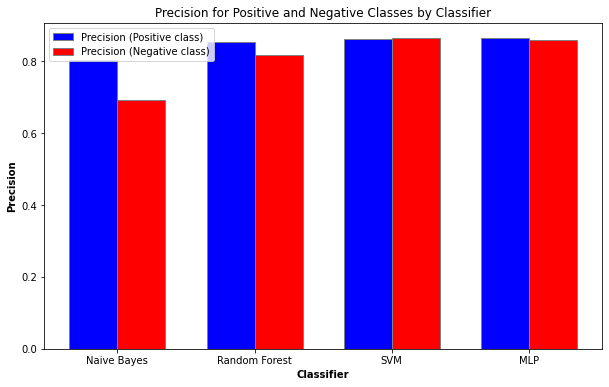

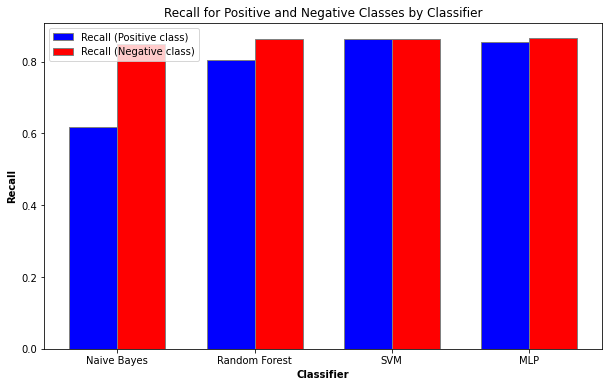

In [42]:
import matplotlib.pyplot as plt

classifiers = ['Naive Bayes', 'Random Forest', 'SVM', 'MLP']
precision_pos_scores = [results_NB['test_precision_pos'], results_RF['test_precision_pos'], results_SVM['test_precision_pos'], results_MLP['test_precision_pos']]
precision_neg_scores = [results_NB['test_precision_neg'], results_RF['test_precision_neg'], results_SVM['test_precision_neg'], results_MLP['test_precision_neg']]

recall_pos_scores = [results_NB['test_recall_pos'], results_RF['test_recall_pos'], results_SVM['test_recall_pos'], results_MLP['test_recall_pos']]
recall_neg_scores = [results_NB['test_recall_neg'], results_RF['test_recall_neg'], results_SVM['test_recall_neg'], results_MLP['test_recall_neg']]

# Set the width of the bars
bar_width = 0.35

# Set the x locations for the groups
r1 = range(len(classifiers))
r2 = [x + bar_width for x in r1]

# Plot the grouped bar plot for precision
plt.figure(figsize=(10, 6))
plt.bar(r1, precision_pos_scores, color='blue', width=bar_width, edgecolor='grey', label='Precision (Positive class)')
plt.bar(r2, precision_neg_scores, color='red', width=bar_width, edgecolor='grey', label='Precision (Negative class)')

# Add xticks on the middle of the group bars
plt.xlabel('Classifier', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(classifiers))], classifiers)

# Add y label
plt.ylabel('Precision', fontweight='bold')

# Add title
plt.title('Precision for Positive and Negative Classes by Classifier')

# Add legend
plt.legend()

# Show plot
plt.show()

# Plot the grouped bar plot for recall
plt.figure(figsize=(10, 6))
plt.bar(r1, recall_pos_scores, color='blue', width=bar_width, edgecolor='grey', label='Recall (Positive class)')
plt.bar(r2, recall_neg_scores, color='red', width=bar_width, edgecolor='grey', label='Recall (Negative class)')

# Add xticks on the middle of the group bars
plt.xlabel('Classifier', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(classifiers))], classifiers)

# Add y label
plt.ylabel('Recall', fontweight='bold')

# Add title
plt.title('Recall for Positive and Negative Classes by Classifier')

# Add legend
plt.legend()

# Show plot
plt.show()

# Added the stacking method to improve accuracy

## About the method:
One way to improve accuracy is to implement stacking. This method generally combines the results of multiple classifiers to improve accuracy. The key advantage of stacking is that it leverages the strengths of multiple models, potentially reducing individual weaknesses and increasing accuracy.

## Steps:
1. **Base Models**: In stacking, you start by training multiple base models on the same dataset. In our case we chose: Naive Bayes, Random Forest, and SVM to be our base models.
2. **Meta-Model**: After training the base models, their predictions are used to create a new dataset. This dataset is then used to train a meta-model. The inputs to the meta-model are the predictions from the base models, and the outputs are the actual target values. In our case, the meta model was MLP.
3. **Final Prediction**: Once the meta-model is trained, it can be used to make predictions on new data. Typically, the base models make predictions, and then the meta-model combines these predictions to produce a final output.


In [44]:
from sklearn.ensemble import StackingClassifier

# Define base classifiers
base_classifiers = [
    ('naive_bayes', GaussianNB()),  # Naïve Bayes
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),  # Random Forest
    ('svm', svm.SVC(kernel='linear'))  # SVM
]

# Define meta-classifier
meta_classifier = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 100), random_state=1)

# Create stacking classifier with base classifiers and MLP as meta
stacking_classifier = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier, cv=10)

# Train the stacking classifier on the training data
stacking_classifier.fit(trainX, trainY["Label"])

# Make predictions on the test data
pred_Y = stacking_classifier.predict(testX)

# Output classification report and confusion matrix
target_names = ['Neg', 'Pos']
print(classification_report(testY["Label"], pred_Y, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(testY["Label"], pred_Y))


              precision    recall  f1-score   support

         Neg       0.83      0.92      0.87       193
         Pos       0.91      0.83      0.87       207

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400

Confusion Matrix:
 [[177  16]
 [ 36 171]]
